In [80]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
# loaded data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

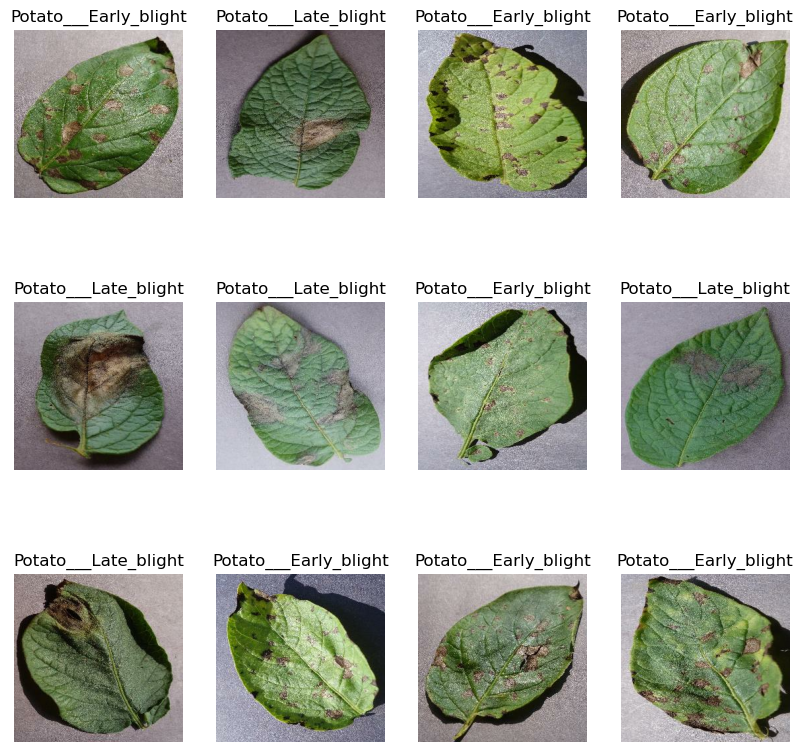

In [6]:
# visualization using matplotlib

plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# divided into train-test-split

def get_dataset_partition_tf(ds, train_split= 0.8, val_split= 0.1, test_split= 0.1, shuffle= True, shuffle_size= 10000):
    ds_size= len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
        
    train_size= int(train_split * ds_size)
    val_size= int(val_split * ds_size)

    train_ds= ds.take(train_size)
    
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds= get_dataset_partition_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(val_ds)

6

In [11]:
len(test_ds)

8

In [12]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [13]:
# creating layers for preprocessing

resize_and_rescale= tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation= tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
# creating model
# defining neural network architecture

input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes= 3
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, activation='relu', kernel_size=(3,3)),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, activation='relu', kernel_size=(3,3)),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation= 'softmax'),
])

model.build(input_shape= input_shape)

C:\Users\palla\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# compile the model

model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
# train the model

history= model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    verbose= 1,
    validation_data= val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 609ms/step - accuracy: 0.4590 - loss: 0.9380 - val_accuracy: 0.5260 - val_loss: 0.8445
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 533ms/step - accuracy: 0.5642 - loss: 0.7775 - val_accuracy: 0.7708 - val_loss: 0.4917
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.8204 - loss: 0.4538 - val_accuracy: 0.8281 - val_loss: 0.3922
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 514ms/step - accuracy: 0.8401 - loss: 0.3492 - val_accuracy: 0.8542 - val_loss: 0.4153
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 517ms/step - accuracy: 0.9216 - loss: 0.2396 - val_accuracy: 0.8594 - val_loss: 0.3475
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 534ms/step - accuracy: 0.9213 - loss: 0.1906 - val_accuracy: 0.8542 - val_loss: 0.5443
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 544ms/step - accuracy: 0.8958 - loss: 0.2426 - val_accuracy: 0.8958 - val_loss: 0.2971
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.9364 - loss: 0.1640 - val_accu

In [19]:
scores= model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9070 - loss: 0.2624


In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [27]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

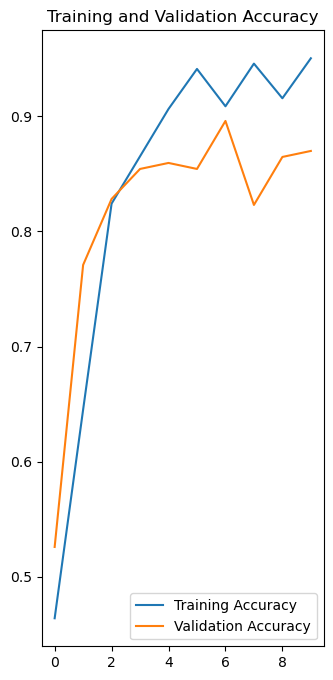

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc,label='Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
predicted label: Potato___Late_blight


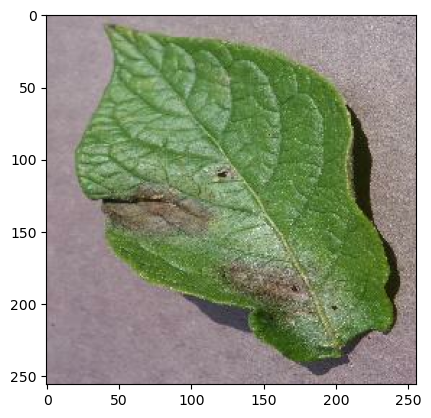

In [51]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.argmax(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


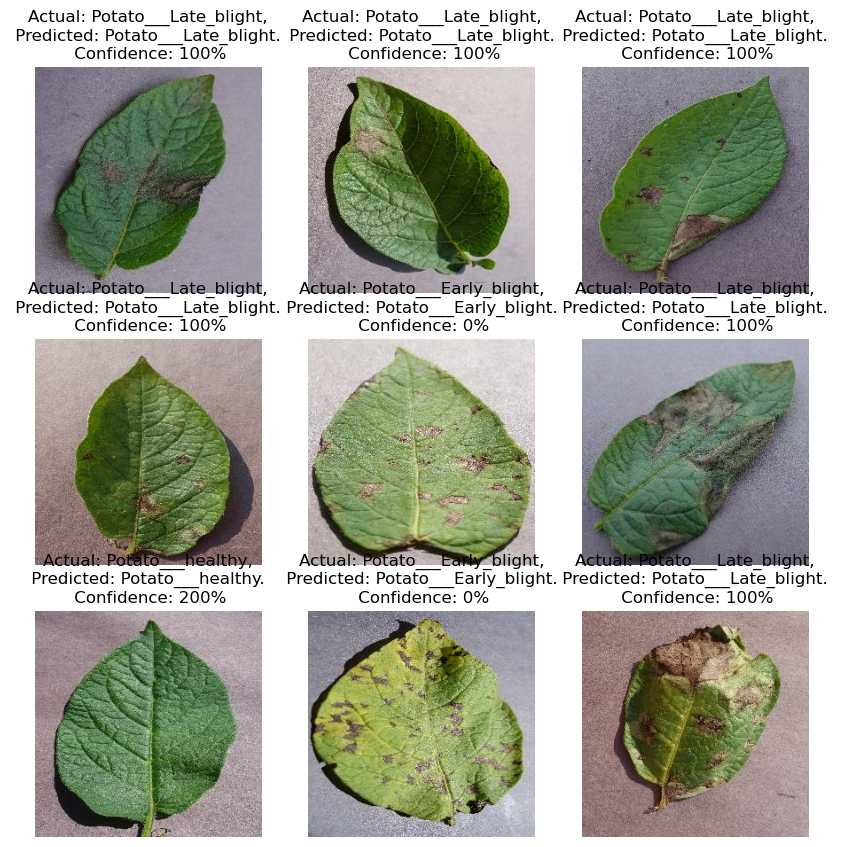

In [56]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")
        

In [81]:
model_version= max([int(i) for i in os.listdir("Models/") + [0]])+1
model.export(f"Models/{model_version}")

INFO:tensorflow:Assets written to: Models/2\assets


INFO:tensorflow:Assets written to: Models/2\assets


Saved artifact at 'Models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1623569536720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623569543632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744072784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744074320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744073552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744075280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744074896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744075664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744073360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744076048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1623744075856: TensorSpec(shape=(), dtype=